# Task10
## VAE and GAN

In [4]:
import tensorflow as tf
tf.__version__
import keras
keras.__version__
tf.compat.v1.disable_eager_execution()

In [5]:
import tensorflow as tf
tf.__version__
import keras
keras.__version__
tf.compat.v1.disable_eager_execution()

import tensorflow
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import Input
import tensorflow as tf
from tensorflow.keras.models import Model 
import numpy as np
from tensorflow.keras.datasets import mnist

In [ ]:
img_shape = (28, 28, 1) 
batch_size = 16
latent_dim = 2

input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x) 
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x) 
z_log_var = layers.Dense(latent_dim)(x)

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon 

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [ ]:
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

x = layers.Reshape(shape_before_flattening[1:])(x) 
x = layers.Conv2DTranspose(32, 3,
                           padding='same',
                           activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3,
                  padding='same',
                  activation='sigmoid')(x)
decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [ ]:
class CustomVariationalLayer(layers.Layer):
    def vae_loss(self, x, z_decoded): 
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = tensorflow.keras.metrics.binary_crossentropy(x, z_decoded) 
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs): 
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded) 
        self.add_loss(loss, inputs=inputs) 
        return x
    
y = CustomVariationalLayer()([input_img, z_decoded])

In [ ]:
input_img.shape

TensorShape([None, 28, 28, 1])

In [ ]:
y.shape

TensorShape([None, 28, 28, 1])

In [ ]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.compile()
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data() 

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,)) 
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,)) 

vae.fit(x=x_train, 
        y=None,
        shuffle=True, 
        epochs=10,
        batch_size=batch_size, 
        validation_data=(x_test, None))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 364s 6ms/sample - loss: 0.2137 - val_loss: 0.1968
Epoch 2/10
60000/60000 [==============================] - 350s 6ms/sample - loss: 0.1925 - val_loss: 0.1920
Epoch 3/10
60000/60000 [==============================] - 347s 6ms/sample - loss: 0.1882 - val_loss: 0.1869
Epoch 4/10
60000/60000 [==============================] - 349s 6ms/sample - loss: 0.1860 - val_loss: 0.1891
Epoch 5/10
60000/60000 [==============================] - 352s 6ms/sample - loss: 0.1844 - val_loss: 0.1835
Epoch 6/10
60000/60000 [==============================] - 354s 6ms/sample - loss: 0.1831 - val_loss: 0.1825
Epoch 7/10
60000/60000 [==============================] - 352s 6ms/sample - loss: 0.1822 - val_loss: 0.1811
Epoch 8/10
60000/60000 [==============================] - 350s 6ms/sample - loss: 0.1815 - val_loss: 0.1822
Epoch 9/10
60000/60000 [==============================] - 351s 6ms/sample - loss: 0.1808 - val_loss: 0.1807
Epoch 10/10
60000/60000 [==============

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


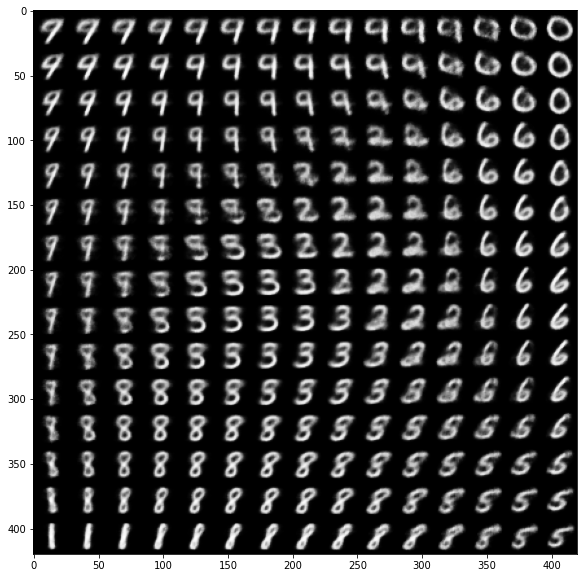

In [ ]:
import matplotlib.pyplot as plt 
from scipy.stats import norm

n=15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n)) 
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n)) 
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2) 
        x_decoded = decoder.predict(z_sample, batch_size=batch_size) 
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

## EXP1) Change num of latent_dim

In [ ]:
import tensorflow as tf
# tf.__version__
import keras
# keras.__version__
# tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

import tensorflow
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import Input
# import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.datasets import mnist

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
img_shape = (28, 28, 1) 
batch_size = 16
latent_dim = 4

input_img = Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x) 
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x) 
z_log_var = layers.Dense(latent_dim)(x)
z = layers.Lambda(sampling)([z_mean, z_log_var])

decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), 
                 activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x) 
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)
decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [ ]:
class CustomVariationalLayer(layers.Layer):
    def vae_loss(self, x, z_decoded): 
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = tensorflow.keras.metrics.binary_crossentropy(x, z_decoded) 
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
        return K.mean(xent_loss + kl_loss)
    
    def call(self, inputs): 
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded) 
        self.add_loss(loss, inputs=inputs) 
        return x
    
y = CustomVariationalLayer()([input_img, z_decoded])

In [ ]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.compile()
vae.summary()

vae.fit(x=x_train, 
        y=None,
        shuffle=True, 
        epochs=10,
        batch_size=batch_size, 
        validation_data=(x_test, None))

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 28, 28, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_6[0][0]']               
                                                                                            

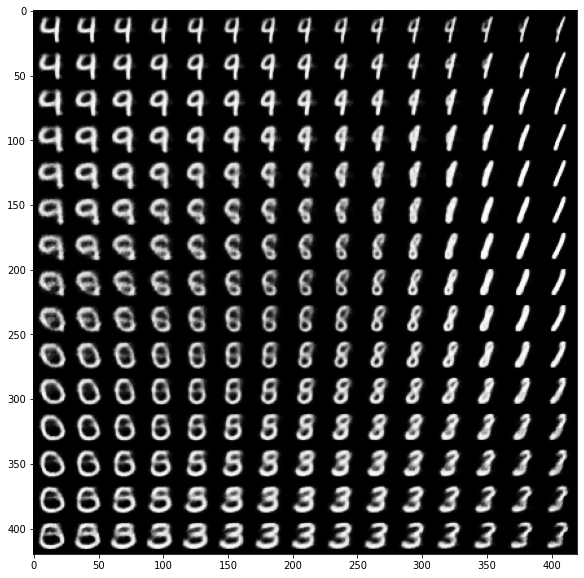

In [ ]:
n=15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n)) 
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n)) 
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(8, latent_dim) 
        x_decoded = decoder.predict(z_sample, batch_size=batch_size) 
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

# GAN

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tensorflow.keras.preprocessing import image
import os

In [12]:
latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = Input(shape=(latent_dim,))

x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)

generator = Model(generator_input, x)
generator.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_2 (Dense)             (None, 32768)             1081344   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 32768)             0         
                                                                 
 reshape_1 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      1048

In [13]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = Model(discriminator_input, x)
discriminator.summary()

discriminator_optimizer = tensorflow.keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 30, 30, 128)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 6, 6, 128)         262272    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 6, 6, 128)         0   

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [14]:
discriminator.trainable = False

gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

gan_optimizer = tensorflow.keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [15]:
(x_train, y_train), (_, _) = tensorflow.keras.datasets.cifar10.load_data()

x_train = x_train[y_train.flatten() == 6]

x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 1000
batch_size = 20

start = 0
for step in range(iterations):
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    generated_images = generator.predict(random_latent_vectors)

    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)

    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0

    if step % 100 == 0:
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img = image.array_to_img(real_images[0] * 255., scale=False)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


discriminator loss at step 0: 0.702536
adversarial loss at step 0: 0.7026268
discriminator loss at step 100: 0.7064765
adversarial loss at step 100: 0.7812684
discriminator loss at step 200: 0.7125635
adversarial loss at step 200: 0.778056
discriminator loss at step 300: 0.6971641
adversarial loss at step 300: 0.80052936
discriminator loss at step 400: 0.69591266
adversarial loss at step 400: 0.7335304
discriminator loss at step 500: 0.68192893
adversarial loss at step 500: 0.7701243
discriminator loss at step 600: 0.6863166
adversarial loss at step 600: 0.7429896
discriminator loss at step 700: 0.69046414
adversarial loss at step 700: 0.6449102
discriminator loss at step 800: 0.6942605
adversarial loss at step 800: 0.7554655
discriminator loss at step 900: 0.6955312
adversarial loss at step 900: 0.74267614


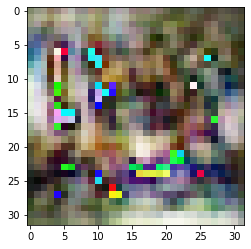

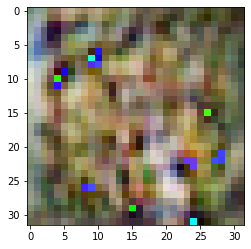

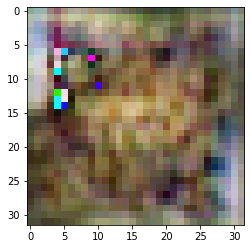

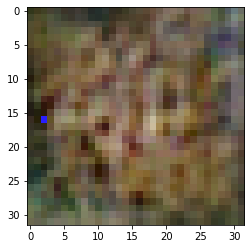

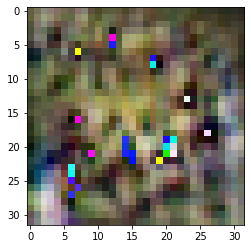

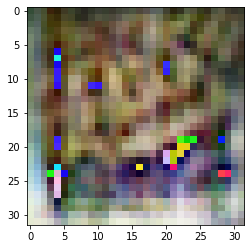

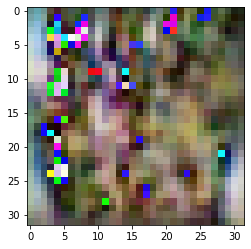

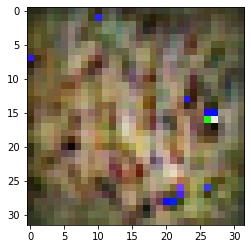

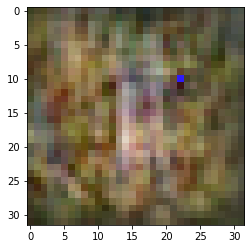

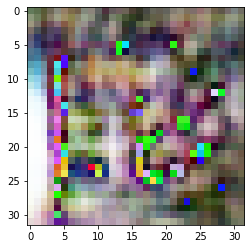

In [17]:
random_latent_vectors = np.random.normal(size=(10, latent_dim))

generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()